# 3.2) 비트코인 시세 예측하기

In [60]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : 시간정보가 포함된 데이터 살펴보기

### 데이터 기본정보 파악

In [61]:
file_path = '../data/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

In [62]:
# 개괄적으로 자료 살펴보기
print(bitcoin_df.shape) # 몇 행 몇 열?
print(bitcoin_df.info()) # day와 price로 구성돼있음을 확인

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [63]:
bitcoin_df.head() # 윗부분

,day,price
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450
3,2017-08-30 00:00:00,4594.987850
4,2017-08-31 00:00:00,4748.255000


In [64]:
bitcoin_df.tail() # 아랫부분

,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


-----

### 시계열 데이터로 변환하기

In [65]:
bitcoin_df.index

RangeIndex(start=0, stop=365, step=1)

In [66]:
bitcoin_df['day']

0      2017-08-27 00:00:00
1      2017-08-28 00:00:00
2      2017-08-29 00:00:00
3      2017-08-30 00:00:00
4      2017-08-31 00:00:00
              ...         
360    2018-08-22 00:00:00
361    2018-08-23 00:00:00
362    2018-08-24 00:00:00
363    2018-08-25 00:00:00
364    2018-08-26 00:00:00
Name: day, Length: 365, dtype: object

In [67]:
# to_datetime으로 day 피처를 시계열 피처로 변환합니다. 
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day']) # 시계열변수로 변환

# index 변환
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True) # 특정 열을 인덱스로 설정
bitcoin_df.head()

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000


In [68]:
bitcoin_df.describe() # 기초통계량 확인

,price
count,365.000000
mean,8395.863578
std,3239.804756
min,3319.630000
25%,6396.772500
50%,7685.633333
75%,9630.136277
max,19498.683333


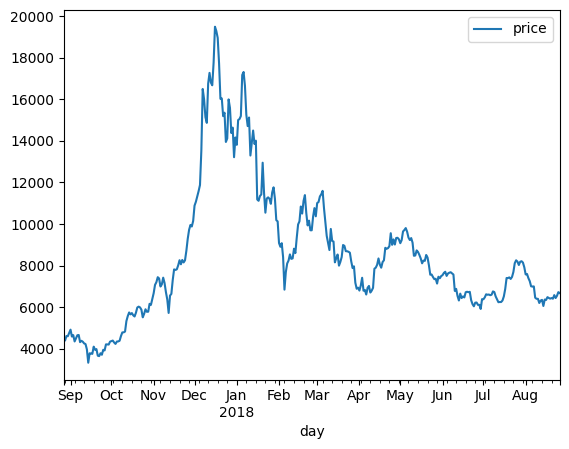

In [69]:
# 데이터 시각화
bitcoin_df.plot()
plt.show()

-----

# <Step2. 예측> : 파이썬 라이브러리를 활용한 시세 예측

### 1. ARIMA 모델 활용하기

#### ARIMA 모델 학습

ARIMA : AR + MA

In [70]:
# from statsmodels.tsa.arima_model import ARIMA ... 사라짐
from statsmodels.tsa.arima.model import ARIMA # ... 바뀐 거
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2)) 

# trend : constant를 갖고 있는지? nc라면 no constant, disp = 수렴 정보 .. 근데 이거 없어짐
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.490
Date:                Sat, 15 Oct 2022   AIC                           5584.980
Time:                        15:57:51   BIC                           5604.466
Sample:                             0   HQIC                          5592.725
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2418      0.305      0.794      0.427      -0.355       0.839
ar.L2          0.6072      0.200      3.038      0.002       0.215       0.999
ma.L1         -0.1513      0.306     -0.495      0.6

-----

#### 모델의 성능 & 예측 결과 시각화
- 학습한 모델이 학습 데이터에 대해서 예측한 결과만을 시각화합니다.

<AxesSubplot: >

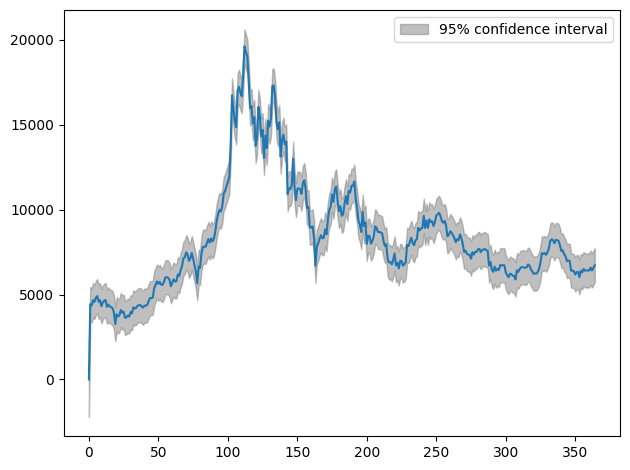

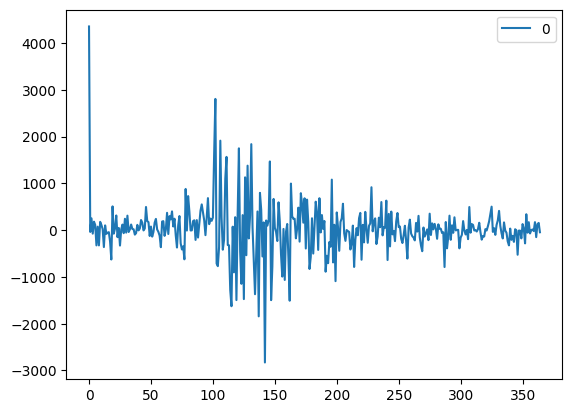

In [100]:
from statsmodels.graphics.tsaplots import plot_predict

# 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)
plot_predict(model_fit)
plt.tight_layout()

# 잔차의 변동을 시각화합니다. (두번째 그래프) .. 매우 불안정함(폭이 일정하지 않음)
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()

#### 실제 데이터와의 비교(모델 평가)
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.
- 5일 후의 실제 데이터는 `'../data/market-price-test.csv'` 에서 불러올 수 있습니다. 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days) 하여 여러분이 직접 만든 모델을 마음대로의 기간으로 예측해 보세요.

In [72]:
# 5일 뒤 예측
forecast_data = model_fit.forecast(steps=5)

In [73]:
forecast_data

array([6672.47137769, 6674.46909301, 6674.46475549, 6675.6767251 ,
       6675.9671885 ])

In [74]:
# 테스트 데이터셋을 불러옵니다.
test_file_path = '../data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

In [75]:
bitcoin_test_df

,ds,y
0,2018-08-27 00:00:00,6719.266154
1,2018-08-28 00:00:00,7000.040000
2,2018-08-29 00:00:00,7054.276429
3,2018-08-30 00:00:00,6932.662500
4,2018-08-31 00:00:00,6981.946154


In [76]:
pred_y = forecast_data.tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values.tolist() # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
# pred_y_lower = min(pred_y) # 마지막 5일의 예측 데이터의 최소값입니다.
# pred_y_upper = max(pred_y) # 마지막 5일의 예측 데이터의 최대값입니다.

In [77]:
pred_y

[6672.471377689288,
 6674.469093009468,
 6674.464755486728,
 6675.676725097829,
 6675.967188500496]

In [78]:
test_y

[6719.266153846153,
 7000.040000000003,
 7054.276428571429,
 6932.662499999999,
 6981.946153846156]

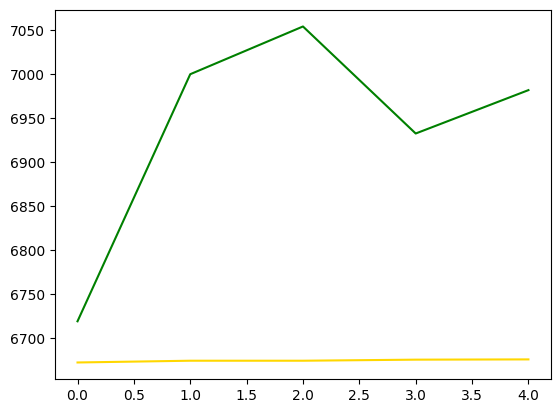

In [82]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
# plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
# plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

In [81]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

287.09158444708197


-----

### 2. Facebook Prophet 활용하기

#### Prophet 모델 학습

In [22]:
!pip install prophet

In [86]:
from prophet import Prophet

In [87]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

16:03:10 - cmdstanpy - INFO - Chain [1] start processing
16:03:11 - cmdstanpy - INFO - Chain [1] done processing


-----

#### 모델로부터 예측할 기간을 정의하고, 결과를 도출.

In [88]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

In [89]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,732.253548,6265.700138,7540.118945,732.253548,732.253548,9.08348,9.08348,9.08348,8.451255,...,-0.007207,-0.007207,-0.007207,-0.625018,-0.625018,-0.625018,0.0,0.0,0.0,6920.715299
366,2018-08-28,736.281885,6318.071729,7663.141169,736.281885,736.281885,9.08348,9.08348,9.08348,8.528661,...,0.017819,0.017819,0.017819,-0.572638,-0.572638,-0.572638,0.0,0.0,0.0,7015.780718
367,2018-08-29,740.310222,6310.041886,7795.392240,740.310222,741.523089,9.08348,9.08348,9.08348,8.505653,...,-0.042363,-0.042363,-0.042363,-0.535464,-0.535464,-0.535464,0.0,0.0,0.0,7037.131717
368,2018-08-30,744.338559,6386.157821,7940.453849,736.414778,757.108603,9.08348,9.08348,9.08348,8.555018,...,-0.012029,-0.012029,-0.012029,-0.516433,-0.516433,-0.516433,0.0,0.0,0.0,7112.168320
369,2018-08-31,748.366896,6432.214591,7991.188815,731.110765,774.817437,9.08348,9.08348,9.08348,8.600805,...,0.035220,0.035220,0.035220,-0.517895,-0.517895,-0.517895,0.0,0.0,0.0,7184.924290


In [90]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6920.715299,6265.700138,7540.118945
366,2018-08-28,7015.780718,6318.071729,7663.141169
367,2018-08-29,7037.131717,6310.041886,7795.392240
368,2018-08-30,7112.168320,6386.157821,7940.453849
369,2018-08-31,7184.924290,6432.214591,7991.188815


-----

#### 결과의 시각화

- 전체 데이터를 기반으로 학습한, 5일 단위의 예측 결과를 시각화합니다.

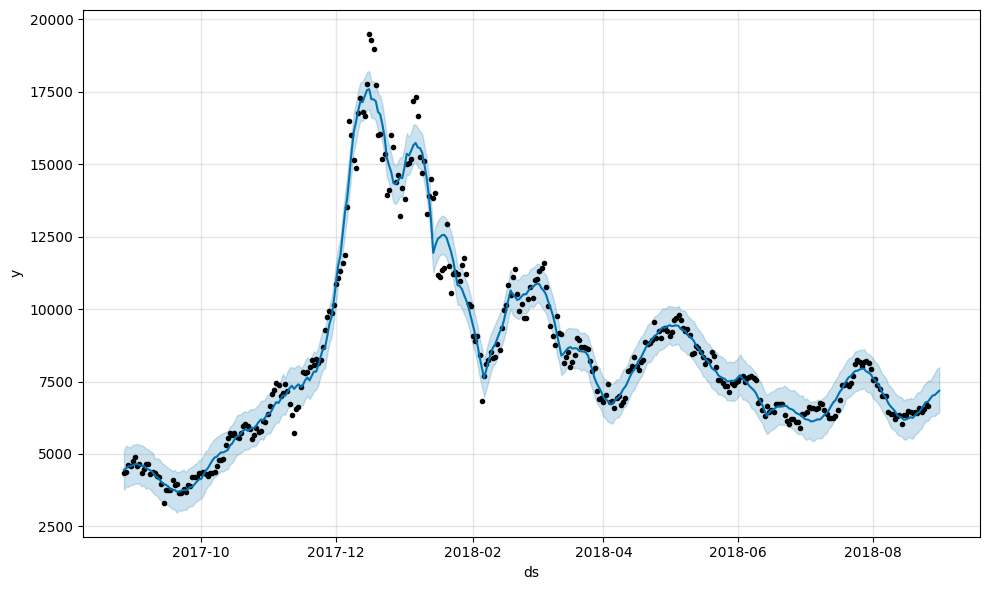

In [91]:
fig1 = prophet.plot(forecast_data)

-----

- seasonality_mode로 설정했었던 기간별 트렌드 정보를 시각화합니다.

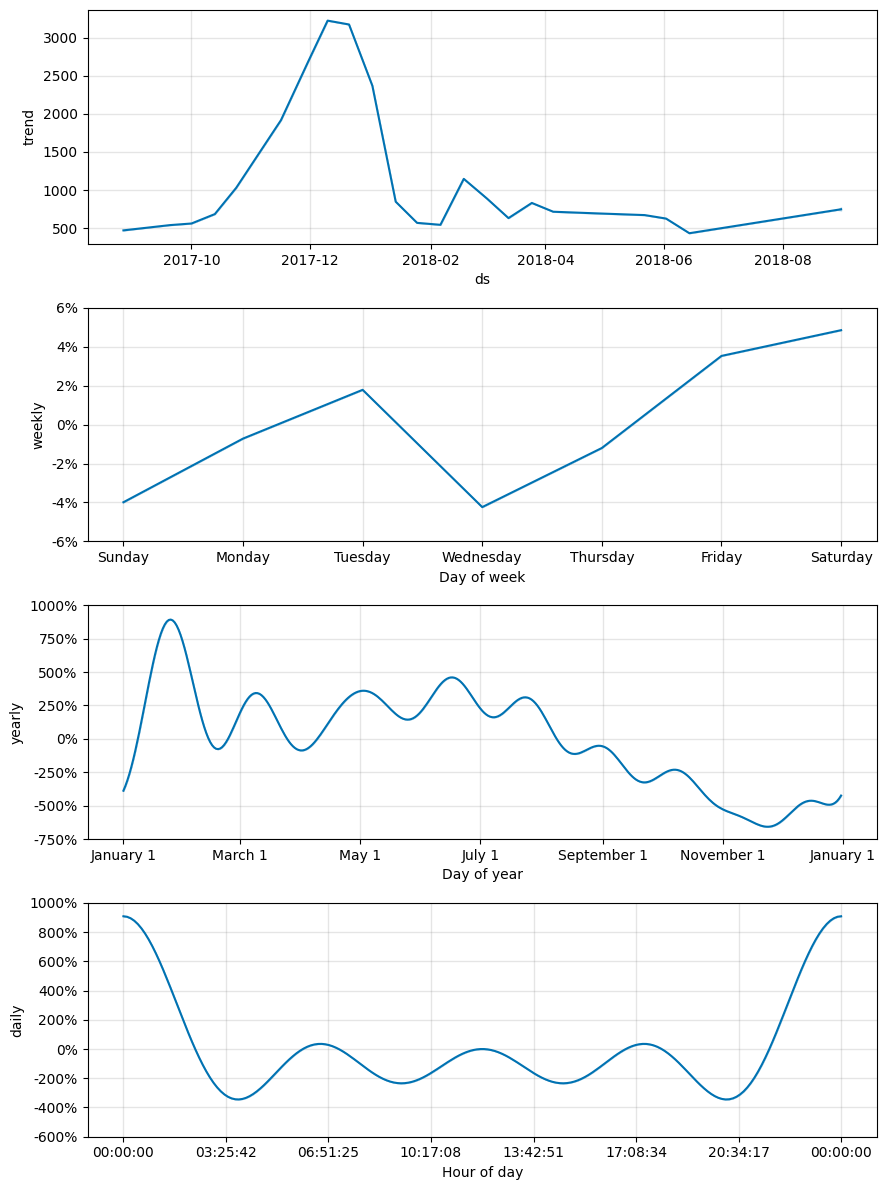

In [92]:
fig2 = prophet.plot_components(forecast_data)
# 첫 번째 그림은 전체

-----

#### 모델의 성능
- 실제 가격과 예측한 가격간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산합니다.

In [93]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터입니다.
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터입니다.

In [31]:
import math
import sys

rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

523.2785518065815
0.9736793061172613


-----

#### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.
- 5일 후의 실제 데이터는 `'../data/market-price-test.csv'` 에서 불러올 수 있습니다. 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days) 하여 여러분이 직접 만든 모델을 마음대로의 기간으로 예측해 보세요.

In [32]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값입니다.

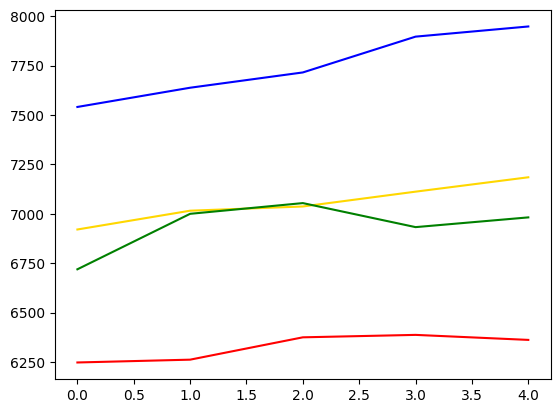

In [33]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

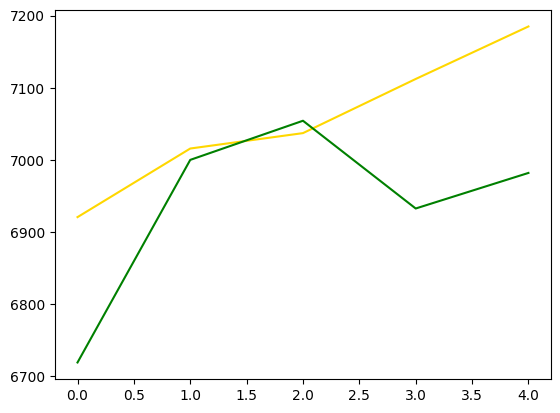

In [34]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

In [35]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

151.3578095716403


-----

# <Step3. 활용> : 더 나은 결과를 위한 방법들

### 상한가 및 하한가 선정

- 주가데이터의 경우 의미가 없지만, 일반적인 시계열 데이터의 경우 상한값 혹은 하한값을 잘 설정해주는 것이 도움이 되기도 합니다.

In [36]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

# 상한가를 설정합니다.
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정합니다.
prophet = Prophet(seasonality_mode='multiplicative', 
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

15:52:35 - cmdstanpy - INFO - Chain [1] start processing
15:52:36 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정합니다.
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

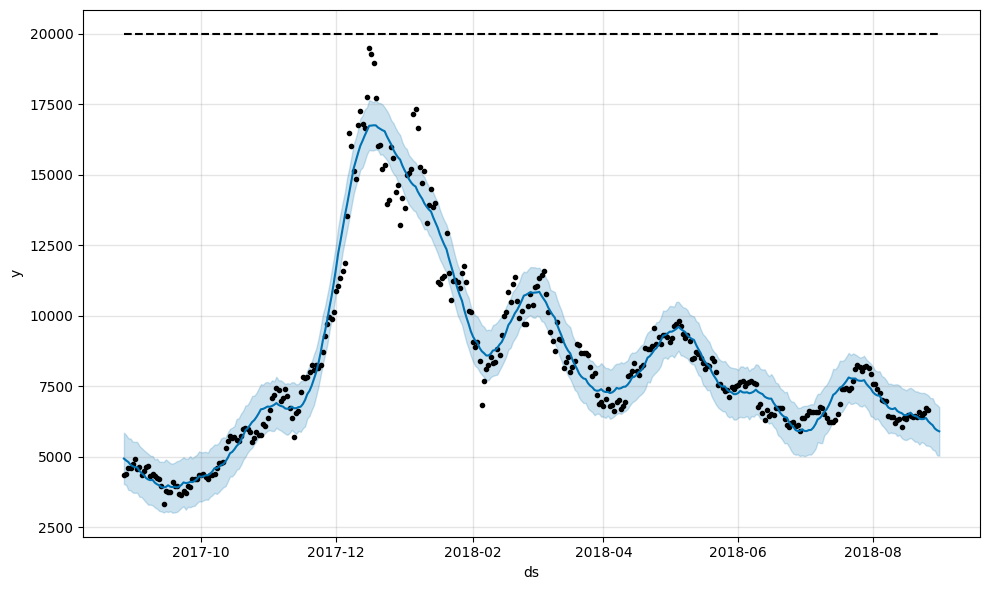

In [38]:
fig = prophet.plot(forecast_data)

-----

#### 실제 데이터와의 비교
- 비트코인 데이터의 경우, 상한선을 둠으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.

In [39]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

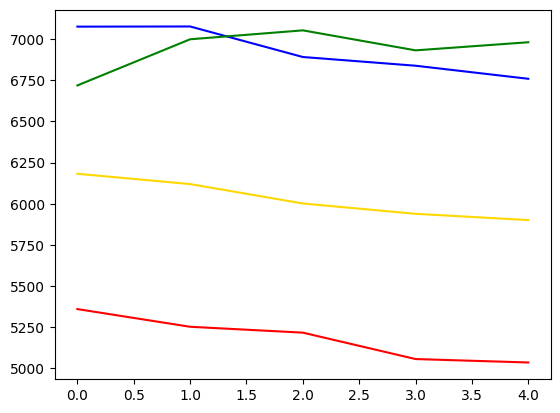

In [40]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

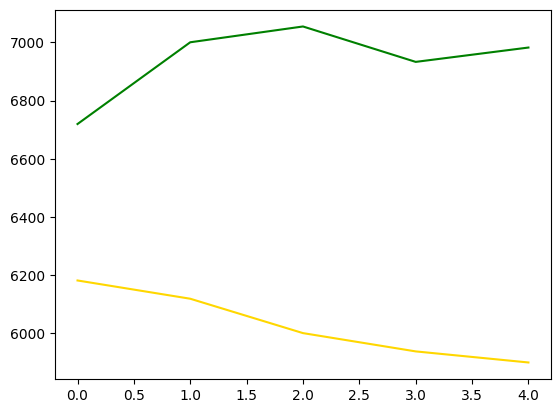

In [41]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

In [42]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

930.8231787790883


-----

#### 이상치 제거하기

- 가격이 18000을 넘어가는 값을 이상치로 판단하여 제거합니다.

In [43]:
# 18000 이상의 데이터는 이상치라고 판단
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

15:52:37 - cmdstanpy - INFO - Chain [1] start processing
15:52:39 - cmdstanpy - INFO - Chain [1] done processing


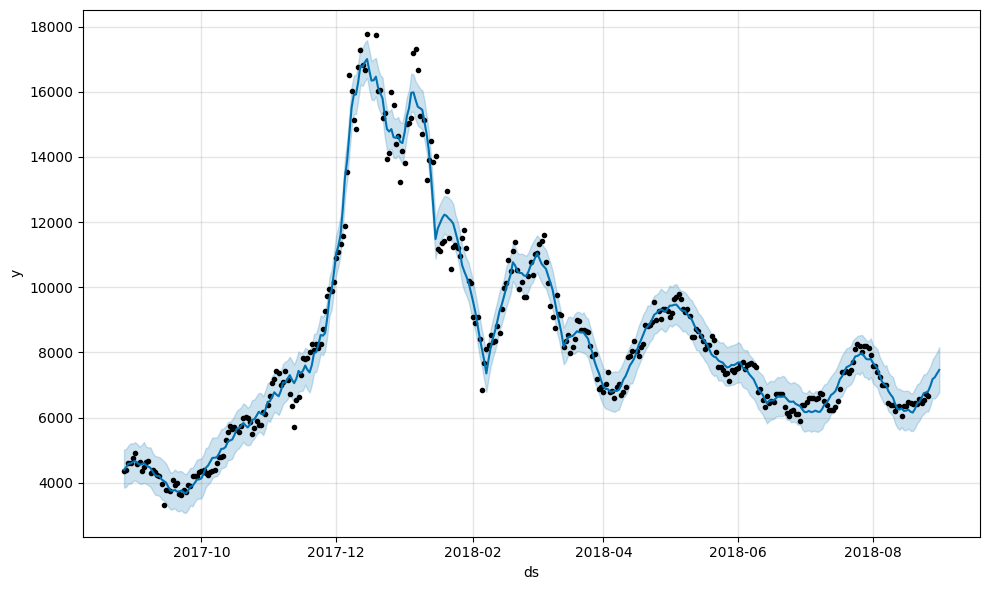

In [44]:
# prophet 모델을 학습합니다.
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력합니다.
fig = prophet.plot(forecast_data)

-----

#### 실제 데이터와의 비교
- 비트코인 데이터의 경우, 이상치를 제거함으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.
- 모델의 정확도 스코어 측면에서는 떨어졌지만, 트렌드 예측의 측면에서는 다소 나은 모습을 보여줄 수도 있습니다.

In [45]:
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

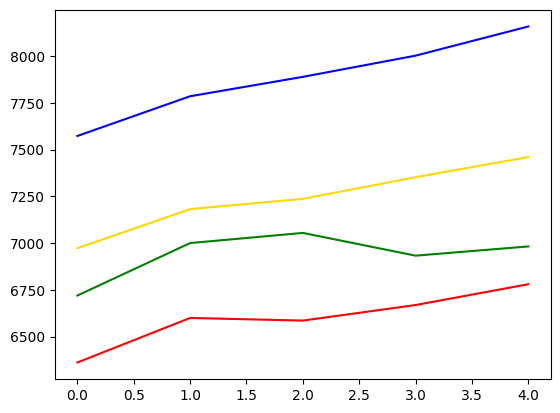

In [46]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

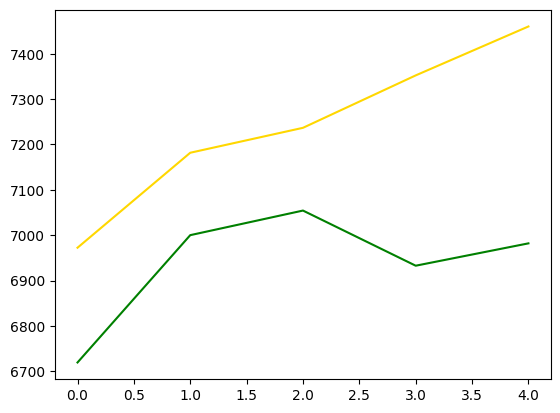

In [47]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

In [48]:
# 테스트 데이터의 RMSE를 출력합니다.
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

327.17749474835404


-----

### `한걸음 더 나아가기`

### ARIMA 모델의 하이퍼 파라미터 선정하기

#### 적절한 파라미터 선정하기
- ARIMA 모델은 p,d,q 세 가지 파라미터를 적절하게 선정하는 것이 가장 중요합니다.
- ACF(Autocorrelation function), PACF(Partial autocorrelation function) 그래프를 통해 대략적인 파라미터를 선정합니다.

In [94]:
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day']) # dtype : object -> datetime
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True) # index를 day열로 바꿈

In [95]:
bitcoin_df

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000
...,...
2018-08-22,6575.229167
2018-08-23,6434.881667
2018-08-24,6543.645714


- https://direction-f.tistory.com/65 : acf와 pacf 차이점

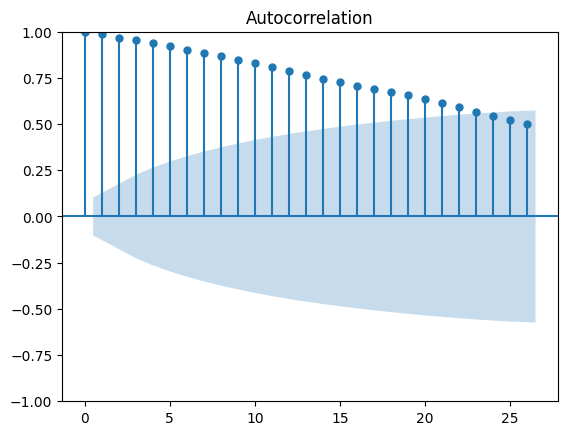

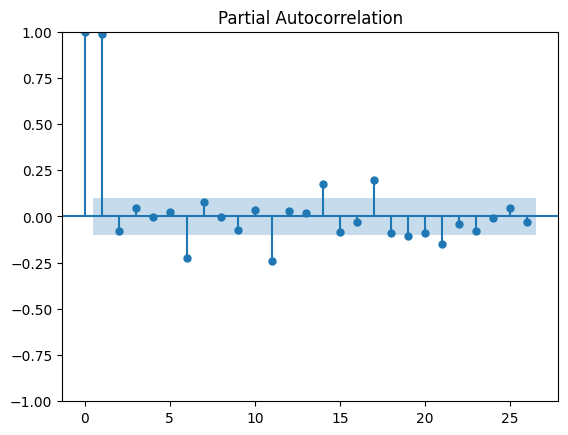

In [96]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin_df.price.values)
plot_pacf(bitcoin_df.price.values)
plt.show()

-----

#### ARIMA 모델 학습
- 그래프를 토대로 1차 학습

In [97]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

model = ARIMA(bitcoin_df.price.values, order=(15,2,0)) # AR=15, 차분=2, MA=0
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                ARIMA(15, 2, 0)   Log Likelihood               -2767.330
Date:                Sat, 15 Oct 2022   AIC                           5566.659
Time:                        16:05:54   BIC                           5628.970
Sample:                             0   HQIC                          5591.427
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8109      0.038    -21.067      0.000      -0.886      -0.735
ar.L2         -0.7800      0.049    -15.761      0.000      -0.877      -0.683
ar.L3         -0.7108      0.055    -12.958      0.0

-----

- 1차 결과를 토대로 2차 학습

In [98]:
model = ARIMA(bitcoin_df.price.values, order=(2,1,2)) # AR=2, 차분=1, MA=2
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.490
Date:                Sat, 15 Oct 2022   AIC                           5584.980
Time:                        16:05:57   BIC                           5604.466
Sample:                             0   HQIC                          5592.725
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2418      0.305      0.794      0.427      -0.355       0.839
ar.L2          0.6072      0.200      3.038      0.002       0.215       0.999
ma.L1         -0.1513      0.306     -0.495      0.6

-----

# 재미로 알아보는 내일의 비트코인 시세

#### 좋은 예측력을 보였던 Prophet 모델로 향후 5일간의 비트코인 시세를 예측해 봅시다.

In [54]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names = ['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

15:52:41 - cmdstanpy - INFO - Chain [1] start processing
15:52:42 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)

In [56]:
# 테스트 데이터를 불러옵니다.
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 마지막 5일의 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

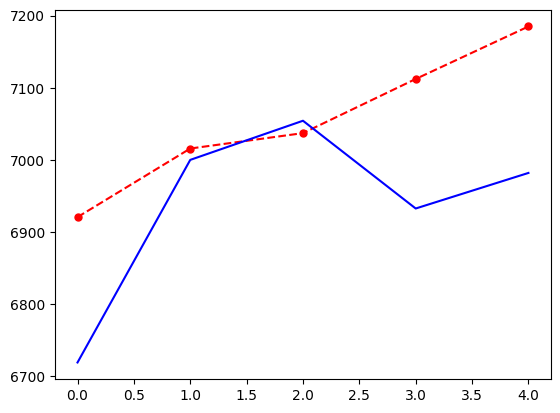

In [57]:
plt.plot(pred_y, color="red", ls="--", marker="o", ms=5) # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="blue") # 실제 가격 그래프입니다.